# Bank Churn Prediction 

## Problem Statement

### Context
Businesses like banks which provide service have to worry about problem of 'Customer Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.


### Objective
You as a Data scientist with the  bank need to  build a neural network based classifier that can determine whether a customer will leave the bank  or not in the next 6 months.

## Data

### Data Dictionary

* CustomerId: Unique ID which is assigned to each customer
* Surname: Last name of the customer
* CreditScore: It defines the credit history of the customer.
* Geography: A customer’s location
* Gender: It defines the Gender of the customer 
* Age: Age of the customer    
* Tenure: Number of years for which the customer has been with the bank
* NumOfProducts: refers to the number of products that a customer has purchased through the bank.
* Balance: Account balance
* HasCrCard: It is a categorical variable which decides whether the customer has credit card or not.
* EstimatedSalary: Estimated salary
* IsActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )
* Exited : whether or not the customer left the bank within six month. It can take two values
    - 0 = No ( Customer did not leave the bank )
    - 1 = Yes ( Customer left the bank )

In [16]:
%%writefile requirements0.txt
tensorflow
scikit-learn
seaborn
matplotlib
numpy
pandas
imbalanced-learn

Overwriting requirements0.txt


In [ ]:
%%writefile requirements_google_colab.txt
tensorflow==2.15.0
scikit-learn==1.2.2
seaborn==0.13.1
matplotlib==3.7.1
numpy==1.25.2 
pandas==2.0.3
imbalanced-learn==0.10.1

In [1]:
import pandas as pd
import numpy as np

In [2]:
import sys
from pathlib import Path

# In notebook
root_dir = Path().resolve().parents[1]  # Adjust if needed
sys.path.append(str(root_dir))

from utils import *

In [3]:
data_dir = '../data'
image_dir = '../images'
data_file_name = "BankChurn.csv"

| Column              | Data Type   | Description                                                                                         |   # unique |
|:--------------------|:------------|:----------------------------------------------------------------------------------------------------|-----------:|
| CustomerId          | int64       | Unique ID which is assigned to each customer                                                        |      10000 |
| Surname             | object      | Last name of the customer                                                                           |       2932 |
| CreditScore         | int64       | It defines the credit history of the customer                                                       |        460 |
| Geography           | object      | Customer’s location                                                                                 |          3 |
| Gender              | object      | It defines the gender of the customer                                                               |          2 |
| Age                 | int64       | Age of the customer                                                                                 |         70 |
| Tenure              | int64       | Number of years for which the customer has been with the bank                                       |         11 |
| Balance          | float64     | Account balance                                                                                     |       6382 |
| NumOfProducts       | int64       | Refers to the number of products that a customer has purchased through the bank                     |          4 |
| HasCrCard           | int64       | It is a categorical variable which decides whether the customer has credit card or not              |          2 |
| IsActiveMember      | int64       | Is is a categorical variable which decides whether the customer is active member of the bank or not |          2 |
| EstimatedSalary  | float64     | Estimated salary                                                                                    |       9999 |
| Exited              | int64       | Whether or not the customer left the bank within six month, 0 = No, 1 = Yes                         |          2 |


In [4]:
df_original = pd.read_csv(f"{data_dir}/{data_file_name}")
df_original = df_original.drop(columns='RowNumber')
for var in ['Balance', 'EstimatedSalary']:
  df_original[var] = df_original[var] / 1000
  df_original.rename(columns={var: f'{var} (K)'}, inplace=True)

In [5]:
import os
#os.getcwd()

In [6]:
display(df_original.head(3))
display(df_original.tail(3))

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance (K),NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary (K),Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00000,1,1,1,101.34888,1
1,15647311,Hill,608,Spain,Female,41,1,83.80786,1,0,1,112.54258,0
2,15619304,Onio,502,France,Female,42,8,159.66080,3,1,0,113.93157,1


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance (K),NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary (K),Exited
9997,15584532,Liu,709,France,Female,36,7,0.00000,1,0,1,42.08558,1
9998,15682355,Sabbatini,772,Germany,Male,42,3,75.07531,2,1,0,92.88852,1
9999,15628319,Walker,792,France,Female,28,4,130.14279,1,1,0,38.19078,0


In [7]:
ddict_str = """CustomerId: Unique ID which is assigned to each customer
Surname: Last name of the customer
CreditScore: It defines the credit history of the customer
Geography: Customer’s location
Gender: It defines the gender of the customer
Age: Age of the customer
Tenure: Number of years for which the customer has been with the bank
NumOfProducts: Refers to the number of products that a customer has purchased through the bank
Balance (K): Account balance
HasCrCard: It is a categorical variable which decides whether the customer has credit card or not
EstimatedSalary (K): Estimated salary
IsActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not
Exited: Whether or not the customer left the bank within six month, 0 = No, 1 = Yes"""

In [8]:
# from sklearn.impute import SimpleImputer

# def impute_data(df):
#   cols_to_impute = df.columns[df.isnull().sum()>0].tolist()
#   cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

#   df_imputed = df.copy()
#   for col in cols_to_impute:
#     strategy = 'most_frequent' if col in cat_cols else 'mean'
#     imputer = SimpleImputer(strategy=strategy)
#     df_imputed[f'{col} (missing)'] = df_imputed[col]
#     df_imputed[[col]] = imputer.fit_transform(df_imputed[[f'{col} (missing)']])
#   return df_imputed

In [10]:
df = df_original.copy()


modify_dict = {}
positive_cols = []
feature_info = {}
drop_cols = ['Surname'] + ['CustomerId']
type_conv = {
    'Exited': 'category',
    'Gender': 'category',
    'Geography': 'category',
    'HasCrCard': 'category',
    'IsActiveMember': 'category',
    'NumOfProducts': 'category'
    }

cat_orders = {}

In [11]:
dfout = create_info_conduct_eda(df.copy(), positive_cols = positive_cols,
                        type_conv = type_conv,
                        feature_info = feature_info,
                  modify_dict = modify_dict,
                            drop_cols = drop_cols, ddict_str = ddict_str,
                             cat_orders=cat_orders, to_plot=False)


Recommendations:
------------------------------------------------------------------------------------------------------------------------
Convert to category: 
type_conv =
{'Exited': 'category',
 'Gender': 'category',
 'Geography': 'category',
 'HasCrCard': 'category',
 'IsActiveMember': 'category',
 'NumOfProducts': 'category'}
cat_orders = 
{}
drop_cols = [] + ['CustomerId']
------------------------------------------------------------------------------------------------------------------------
There are 10,000 (~10K) _rows_ and 13 _columns_ in the dataset.

The __memory usage__ is approximately  1015.8 KB.

There are __no missing__ values in the data.

There are __no duplicated__ rows in the data.

Anamolous Values

No feature engineering is done.

Column(s) Surname, CustomerId is/are dropped.

'Exited' is converted to category type.
'Gender' is converted to category type.
'Geography' is converted to category type.
'HasCrCard' is converted to category type.
'IsActiveMember' is conver

,Data Type,Description,# unique
Column,,,
CustomerId,int64,Unique ID which is assigned to each customer,10000
Surname,object,Last name of the customer,2932
CreditScore,int64,It defines the credit history of the customer,460
Geography,object,Customer’s location,3
Gender,object,It defines the gender of the customer,2
Age,int64,Age of the customer,70
Tenure,int64,Number of years for which the customer has bee...,11
Balance (K),float64,Account balance,6382
NumOfProducts,int64,Refers to the number of products that a custom...,4


,
Memory Usage,1015.8 KB
,
#,
Rows,10000
Columns,13
Null Values,0
Duplicated Rows,0
,
int64,8
object,3


""


,Data Type,Description,# unique
Column,,,
CreditScore,int64,It defines the credit history of the customer,460
Geography,category,Customer’s location,3
Gender,category,It defines the gender of the customer,2
Age,int64,Age of the customer,70
Tenure,int64,Number of years for which the customer has bee...,11
Balance (K),float64,Account balance,6382
NumOfProducts,category,Refers to the number of products that a custom...,4
HasCrCard,category,It is a categorical variable which decides whe...,2
IsActiveMember,category,Is is a categorical variable which decides whe...,2


,
Memory Usage,450.2 KB
,
#,
Rows,10000
Columns,11
Null Values,0
Duplicated Rows,0
,
category,6
int64,3


""


,unique,top,freq
Object/Categorical Column,,,
Geography,3,France,5014
Gender,2,Male,5457
NumOfProducts,4,1,5084
HasCrCard,2,1,7055
IsActiveMember,2,1,5151
Exited,2,0,7963


,mean,std,min,25%,50%,75%,max,IQR,# Outliers (Upper),# Outliers (Lower),# Outliers,Outliers %
Numerical Column,,,,,,,,,,,,
CreditScore,650.5,96.7,350.00000,584.00000,652.000000,718.000000,850.00000,134.000000,0,16,16,0.2
Age,38.9,10.5,18.00000,32.00000,37.000000,44.000000,92.00000,12.000000,411,0,411,4.1
Tenure,5.0,2.9,0.00000,3.00000,5.000000,7.000000,10.00000,4.000000,0,0,0,0.0
Balance (K),76.5,62.4,0.00000,0.00000,97.198540,127.644240,250.89809,127.644240,0,0,0,0.0
EstimatedSalary (K),100.1,57.5,0.01158,51.00211,100.193915,149.388247,199.99248,98.386137,0,0,0,0.0


Information is written to info_dataframes.md


In [12]:
dfout.to_csv(f'{data_dir}/BankChurn_clean.csv', index=False)

In [13]:
target = 'Exited'
dfoutdimmies = pd.get_dummies(dfout, columns=dfout.select_dtypes(include=['category']).columns.tolist(), drop_first=True)

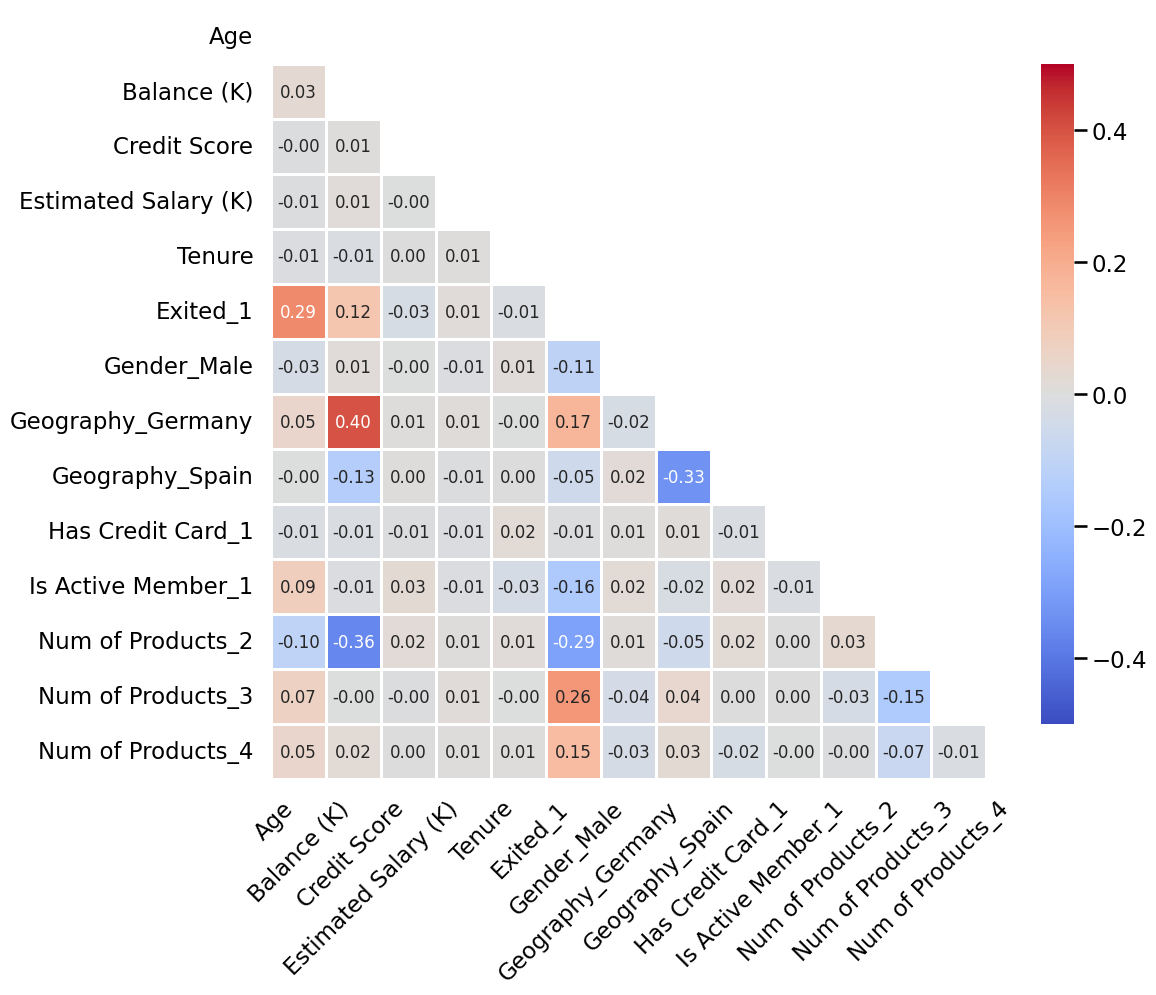

In [14]:
heatmap(dfoutdimmies.corr(), figsize=(18, 10), corner = True, name='heatmap_all', rotation_y=0)

Recommendations:
------------------------------------------------------------------------------------------------------------------------
Convert to category: 
type_conv =
{'Exited': 'category',
 'Gender': 'category',
 'Geography': 'category',
 'HasCrCard': 'category',
 'IsActiveMember': 'category',
 'NumOfProducts': 'category'}
cat_orders = 
{}
drop_cols = [] + ['CustomerId']
------------------------------------------------------------------------------------------------------------------------
There are 10,000 (~10K) _rows_ and 13 _columns_ in the dataset.

The __memory usage__ is approximately  1015.8 KB.

There are __no missing__ values in the data.

There are __no duplicated__ rows in the data.

Anamolous Values

No feature engineering is done.

Column(s) Surname, CustomerId is/are dropped.

'Exited' is converted to category type.
'Gender' is converted to category type.
'Geography' is converted to category type.
'HasCrCard' is converted to category type.
'IsActiveMember' is conver

,Data Type,Description,# unique
Column,,,
CustomerId,int64,Unique ID which is assigned to each customer,10000
Surname,object,Last name of the customer,2932
CreditScore,int64,It defines the credit history of the customer,460
Geography,object,Customer’s location,3
Gender,object,It defines the gender of the customer,2
Age,int64,Age of the customer,70
Tenure,int64,Number of years for which the customer has bee...,11
Balance (K),float64,Account balance,6382
NumOfProducts,int64,Refers to the number of products that a custom...,4


,
Memory Usage,1015.8 KB
,
#,
Rows,10000
Columns,13
Null Values,0
Duplicated Rows,0
,
int64,8
object,3


""


,Data Type,Description,# unique
Column,,,
CreditScore,int64,It defines the credit history of the customer,460
Geography,category,Customer’s location,3
Gender,category,It defines the gender of the customer,2
Age,int64,Age of the customer,70
Tenure,int64,Number of years for which the customer has bee...,11
Balance (K),float64,Account balance,6382
NumOfProducts,category,Refers to the number of products that a custom...,4
HasCrCard,category,It is a categorical variable which decides whe...,2
IsActiveMember,category,Is is a categorical variable which decides whe...,2


,
Memory Usage,450.2 KB
,
#,
Rows,10000
Columns,11
Null Values,0
Duplicated Rows,0
,
category,6
int64,3


""


,unique,top,freq
Object/Categorical Column,,,
Geography,3,France,5014
Gender,2,Male,5457
NumOfProducts,4,1,5084
HasCrCard,2,1,7055
IsActiveMember,2,1,5151
Exited,2,0,7963


,mean,std,min,25%,50%,75%,max,IQR,# Outliers (Upper),# Outliers (Lower),# Outliers,Outliers %
Numerical Column,,,,,,,,,,,,
CreditScore,650.5,96.7,350.00000,584.00000,652.000000,718.000000,850.00000,134.000000,0,16,16,0.2
Age,38.9,10.5,18.00000,32.00000,37.000000,44.000000,92.00000,12.000000,411,0,411,4.1
Tenure,5.0,2.9,0.00000,3.00000,5.000000,7.000000,10.00000,4.000000,0,0,0,0.0
Balance (K),76.5,62.4,0.00000,0.00000,97.198540,127.644240,250.89809,127.644240,0,0,0,0.0
EstimatedSalary (K),100.1,57.5,0.01158,51.00211,100.193915,149.388247,199.99248,98.386137,0,0,0,0.0


Information is written to info_dataframes.md

Exited
The majority are not Exited(Exited) (79.6%).

Gender
The most common value in Gender(Gender) is Male (54.6%).

Geography
The most common value in Geography(Geography) is France (50.1%).

HasCrCard
The majority are Has Credit Card(HasCrCard) (70.5%).

IsActiveMember
The majority are Is Active Member(IsActiveMember) (51.5%).

NumOfProducts
The most common value in Num of Products(NumOfProducts) is 1 (50.8%) followed by 2 (45.9%).

Age
Age(Age) is highly positively skewed (right-skewed) (skewness:  1.01) with average of 38.92.
The data Age(Age)  may NOT be normally distributed.
Percentage of Age(Age) outliers using IQR: 3.59%
Percentage of Age(Age) outliers using Z-score: 1.33%

Balance (K)
Balance (K)(Balance (K)) is slightly negatively skewed (left-skewed) (skewness: -0.14) with average of 76.49.
The data Balance (K)(Balance (K))  may NOT be normally distributed.
Percentage of Balance (K)(Balance (K)) outliers using IQR: 0.00%
Percent

,Variable 1,Variable 2,Correlation
0,Age,Balance (K),0.028308
1,Balance (K),EstimatedSalary (K),0.012797
2,EstimatedSalary (K),Tenure,0.007784
3,Balance (K),CreditScore,0.006268
4,CreditScore,Tenure,0.000842
5,CreditScore,EstimatedSalary (K),-0.001384
6,Age,CreditScore,-0.003965
7,Age,EstimatedSalary (K),-0.007201
8,Age,Tenure,-0.009997
9,Balance (K),Tenure,-0.012254


,Exited,Gender,Geography,HasCrCard,IsActiveMember,NumOfProducts
Exited,1.000000,0.011182,0.027730,0.000050,0.024316,0.138388
Gender,0.011182,1.000000,0.000502,0.000024,0.000369,0.001482
Geography,0.027730,0.000502,1.000000,0.000107,0.000255,0.002344
HasCrCard,0.000050,0.000024,0.000107,1.000000,0.000116,0.000031
IsActiveMember,0.024316,0.000369,0.000255,0.000116,1.000000,0.001243
NumOfProducts,0.138388,0.001482,0.002344,0.000031,0.001243,1.000000


Exited HAS AN EFFECT on NumOfProducts as the p_value 0.0e+00 < 0.05.
Exited HAS AN EFFECT on Geography as the p_value 3.8e-66 < 0.05.
Exited HAS AN EFFECT on IsActiveMember as the p_value 8.8e-55 < 0.05.
Exited HAS AN EFFECT on Gender as the p_value 2.2e-26 < 0.05.
Geography HAS AN EFFECT on NumOfProducts as the p_value 6.7e-09 < 0.05.
Gender HAS AN EFFECT on NumOfProducts as the p_value 1.3e-04 < 0.05.
IsActiveMember HAS AN EFFECT on NumOfProducts as the p_value 6.4e-04 < 0.05.
Gender HAS AN EFFECT on IsActiveMember as the p_value 2.5e-02 < 0.05.
Gender HAS AN EFFECT on Geography as the p_value 3.1e-02 < 0.05.


,Category 1,Category 2,p-value
0,Exited,NumOfProducts,0.0e+00
1,Exited,Geography,3.8e-66
2,Exited,IsActiveMember,8.8e-55
3,Exited,Gender,2.2e-26
4,Geography,NumOfProducts,6.7e-09
5,Gender,NumOfProducts,1.3e-04
6,IsActiveMember,NumOfProducts,6.4e-04
7,Gender,IsActiveMember,2.5e-02
8,Gender,Geography,3.1e-02


Geography HAS AN EFFECT on Balance (K) as the One-Way ANOVA F-test p_value 0.0e+00 < 0.05.
NumOfProducts HAS AN EFFECT on Balance (K) as the One-Way ANOVA F-test p_value 3.7e-315 < 0.05.
Exited HAS AN EFFECT on Age as the Two-Sample T-Test p_value 1.2e-186 < 0.05.
NumOfProducts HAS AN EFFECT on Age as the One-Way ANOVA F-test p_value 5.2e-33 < 0.05.
Exited HAS AN EFFECT on Balance (K) as the Two-Sample T-Test p_value 1.3e-32 < 0.05.
IsActiveMember HAS AN EFFECT on Age as the Two-Sample T-Test p_value 1.1e-17 < 0.05.
Geography HAS AN EFFECT on Age as the One-Way ANOVA F-test p_value 5.6e-06 < 0.05.
IsActiveMember HAS AN EFFECT on Tenure as the Two-Sample T-Test p_value 4.6e-03 < 0.05.
Gender HAS AN EFFECT on Age as the Two-Sample T-Test p_value 5.9e-03 < 0.05.
Exited HAS AN EFFECT on CreditScore as the Two-Sample T-Test p_value 6.7e-03 < 0.05.
IsActiveMember HAS AN EFFECT on CreditScore as the Two-Sample T-Test p_value 1.0e-02 < 0.05.
HasCrCard HAS AN EFFECT on Tenure as the Two-Sample 

,Category,Numerical,p-value
0,Geography,Balance (K),0.0e+00
1,NumOfProducts,Balance (K),3.7e-315
2,Exited,Age,1.2e-186
3,NumOfProducts,Age,5.2e-33
4,Exited,Balance (K),1.3e-32
5,IsActiveMember,Age,1.1e-17
6,Geography,Age,5.6e-06
7,IsActiveMember,Tenure,4.6e-03
8,Gender,Age,5.9e-03
9,Exited,CreditScore,6.7e-03


Geography HAS AN EFFECT on Balance (K) as the One-Way ANOVA F-test p_value 0.0e+00 < 0.05.
NumOfProducts HAS AN EFFECT on Balance (K) as the One-Way ANOVA F-test p_value 3.7e-315 < 0.05.
Exited HAS AN EFFECT on Age as the Two-Sample T-Test p_value 1.2e-186 < 0.05.
NumOfProducts HAS AN EFFECT on Age as the One-Way ANOVA F-test p_value 5.2e-33 < 0.05.
Exited HAS AN EFFECT on Balance (K) as the Two-Sample T-Test p_value 1.3e-32 < 0.05.
IsActiveMember HAS AN EFFECT on Age as the Two-Sample T-Test p_value 1.1e-17 < 0.05.
Geography HAS AN EFFECT on Age as the One-Way ANOVA F-test p_value 5.6e-06 < 0.05.
IsActiveMember HAS AN EFFECT on Tenure as the Two-Sample T-Test p_value 4.6e-03 < 0.05.
Gender HAS AN EFFECT on Age as the Two-Sample T-Test p_value 5.9e-03 < 0.05.
Exited HAS AN EFFECT on CreditScore as the Two-Sample T-Test p_value 6.7e-03 < 0.05.
IsActiveMember HAS AN EFFECT on CreditScore as the Two-Sample T-Test p_value 1.0e-02 < 0.05.
HasCrCard HAS AN EFFECT on Tenure as the Two-Sample 

,Category,Numerical,p-value
0,Geography,Balance (K),0.0e+00
1,NumOfProducts,Balance (K),3.7e-315
2,Exited,Age,1.2e-186
3,NumOfProducts,Age,5.2e-33
4,Exited,Balance (K),1.3e-32
5,IsActiveMember,Age,1.1e-17
6,Geography,Age,5.6e-06
7,IsActiveMember,Tenure,4.6e-03
8,Gender,Age,5.9e-03
9,Exited,CreditScore,6.7e-03


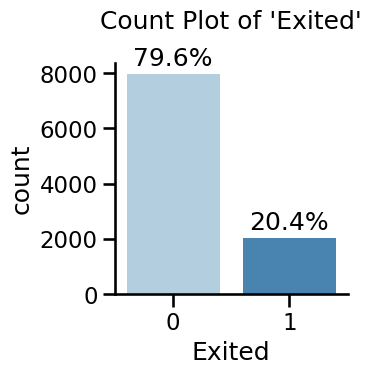

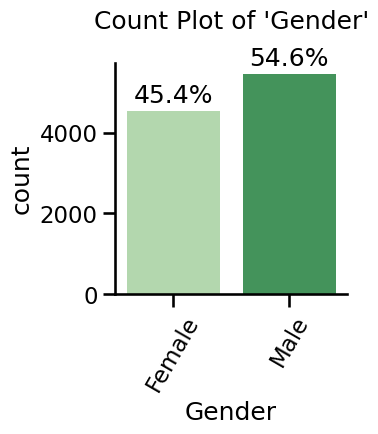

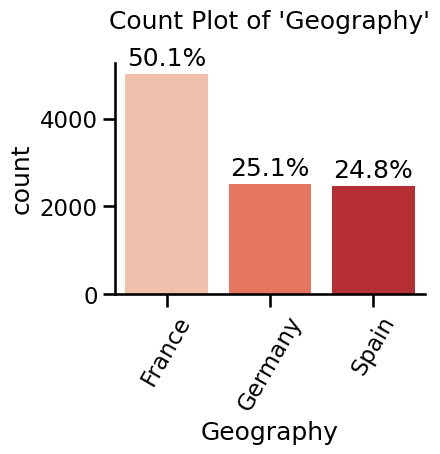

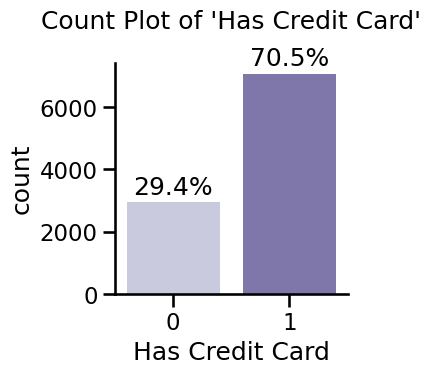

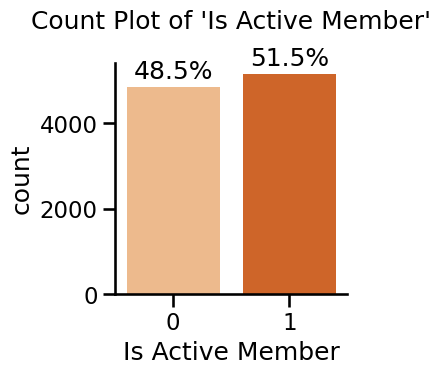

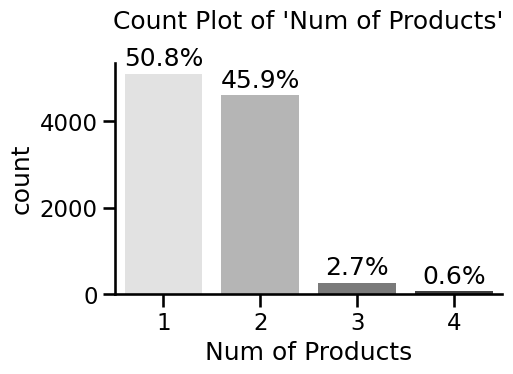

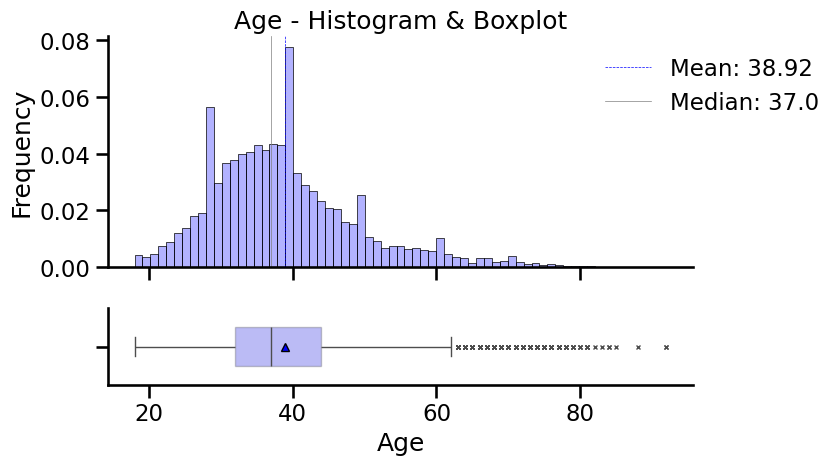

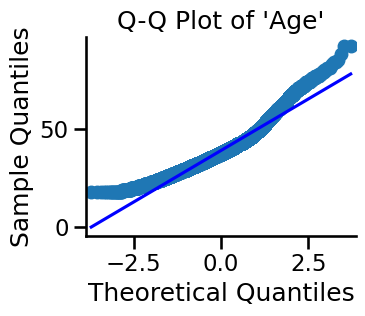

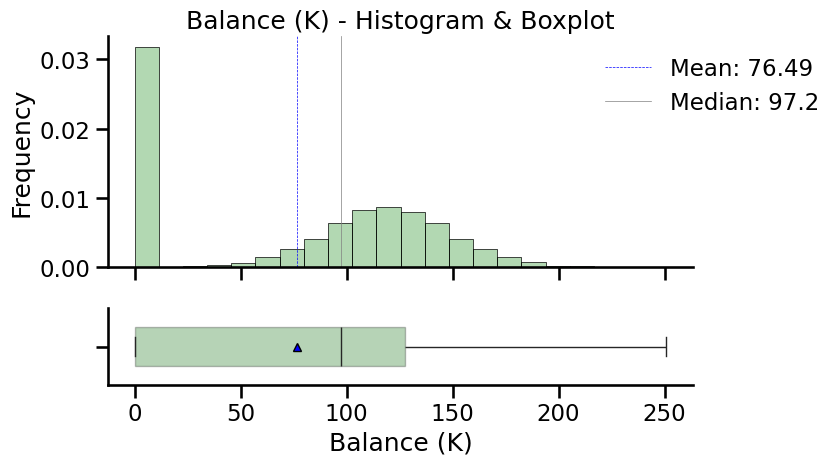

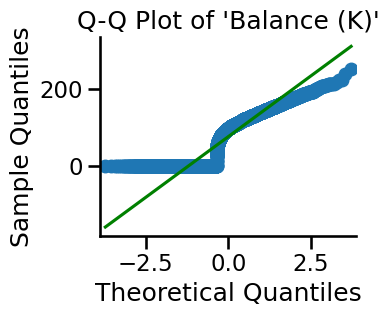

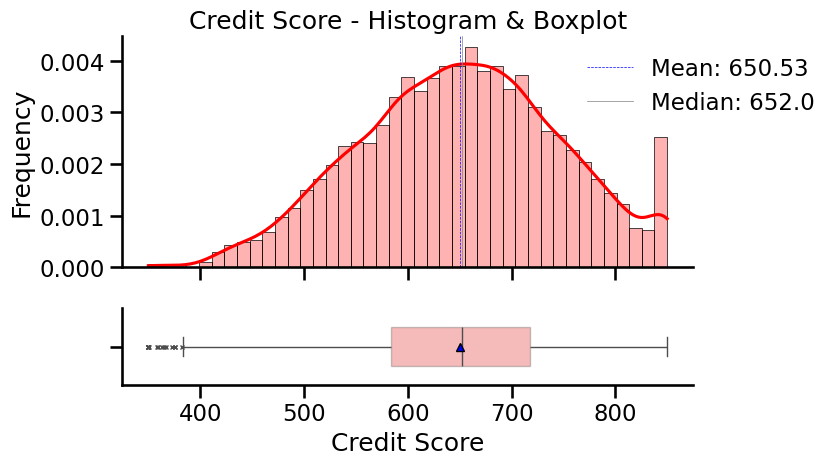

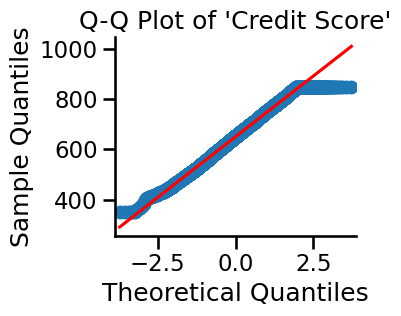

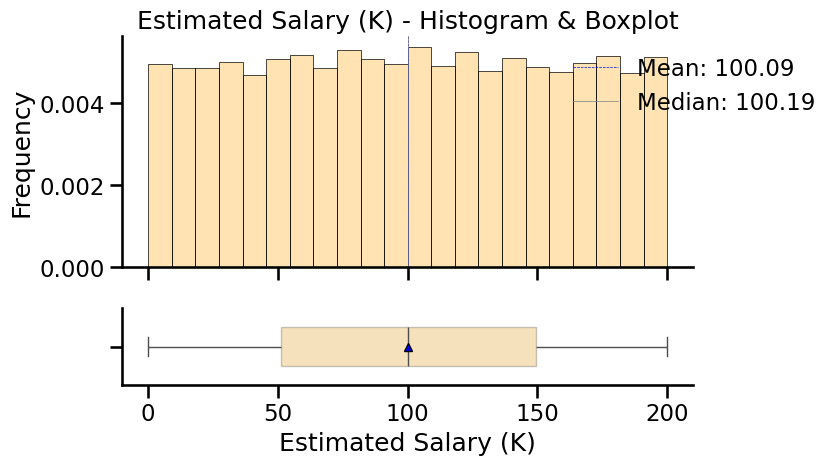

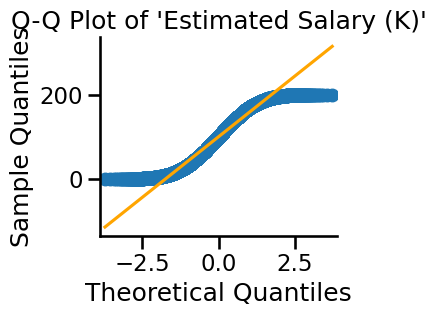

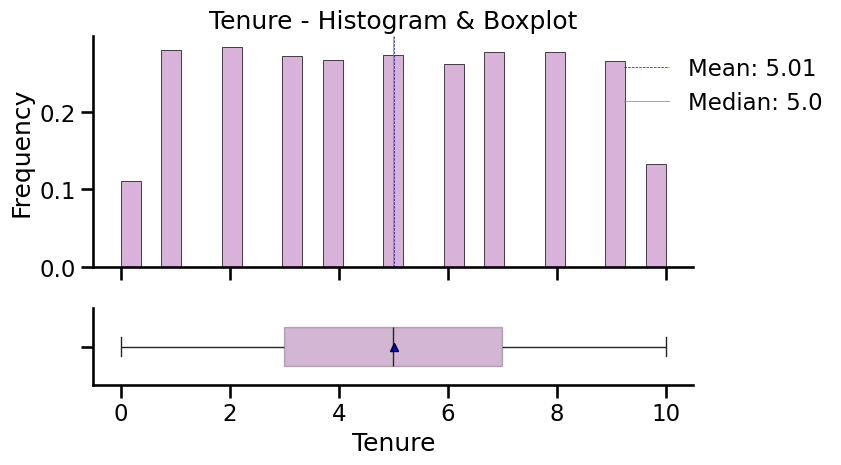

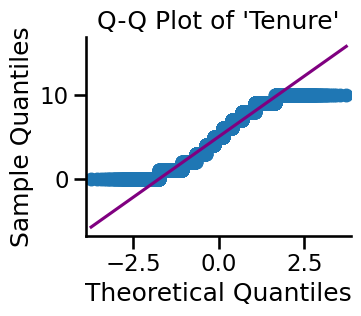

<Figure size 1300x1300 with 0 Axes>

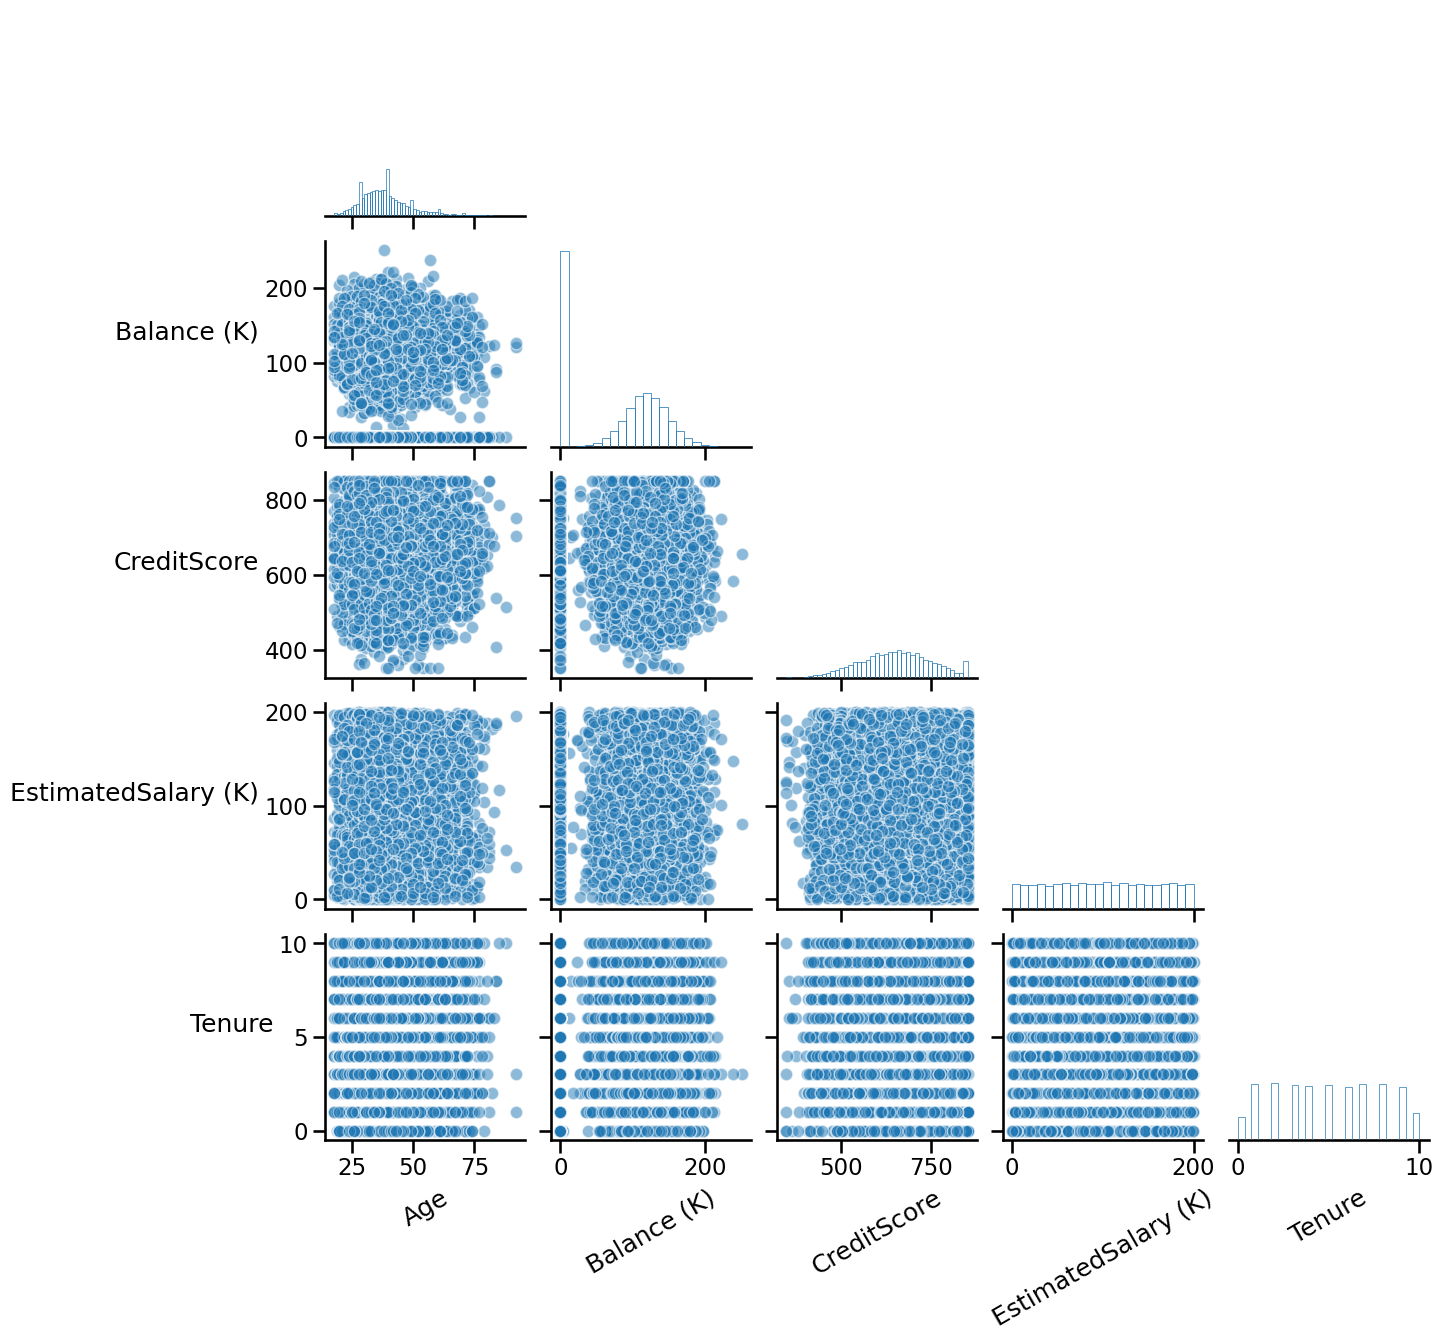

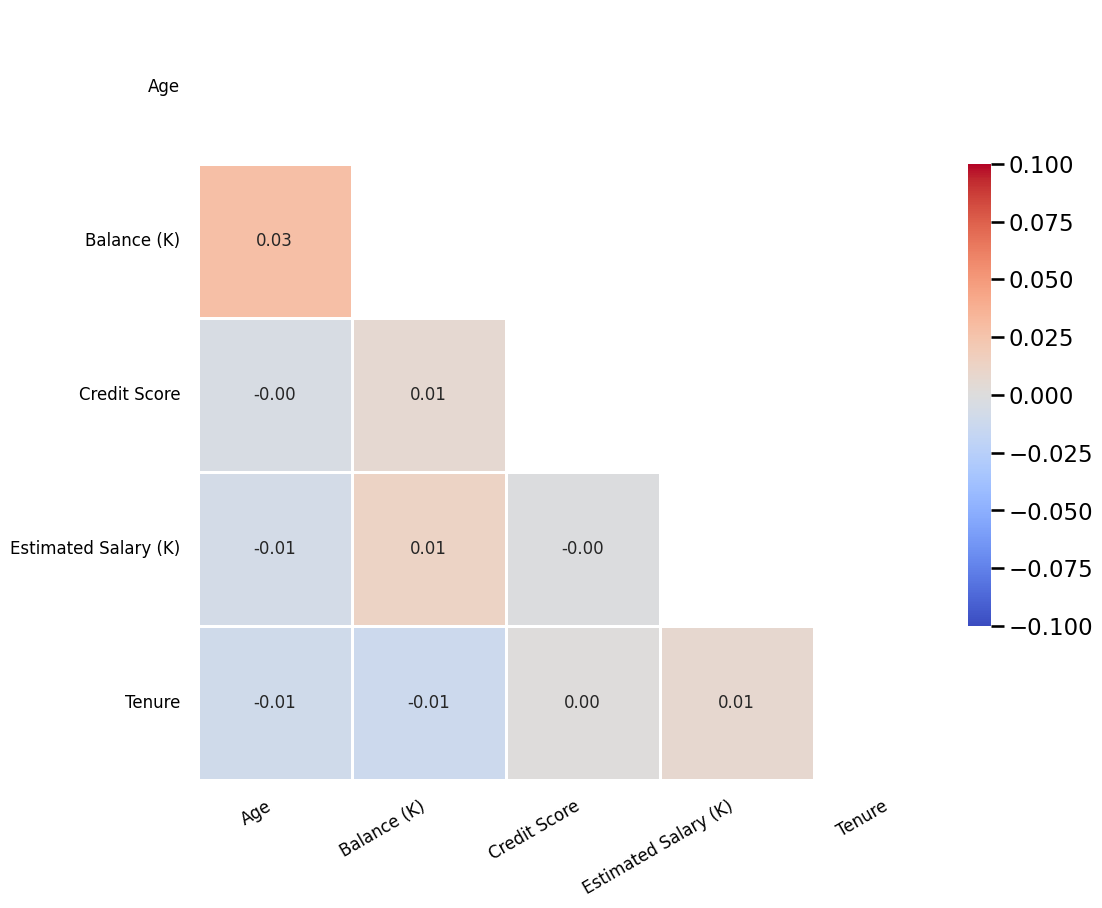

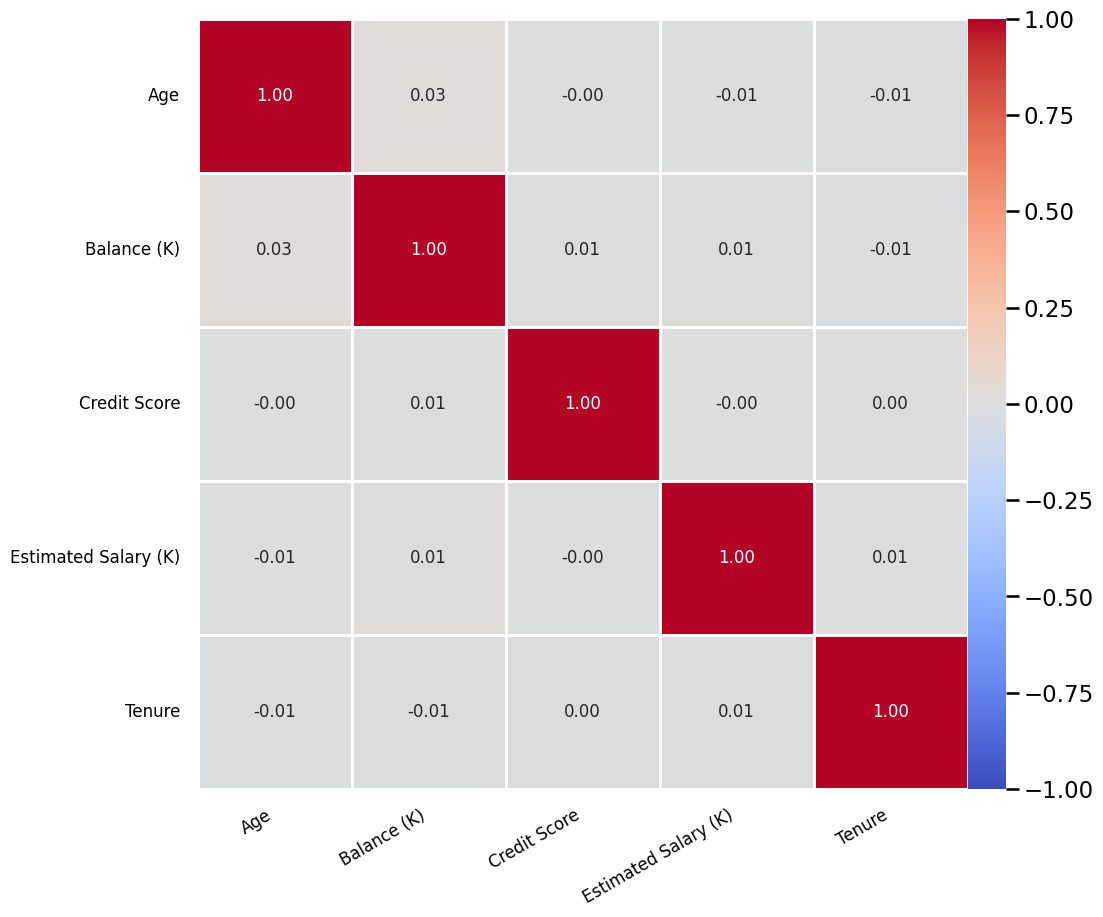

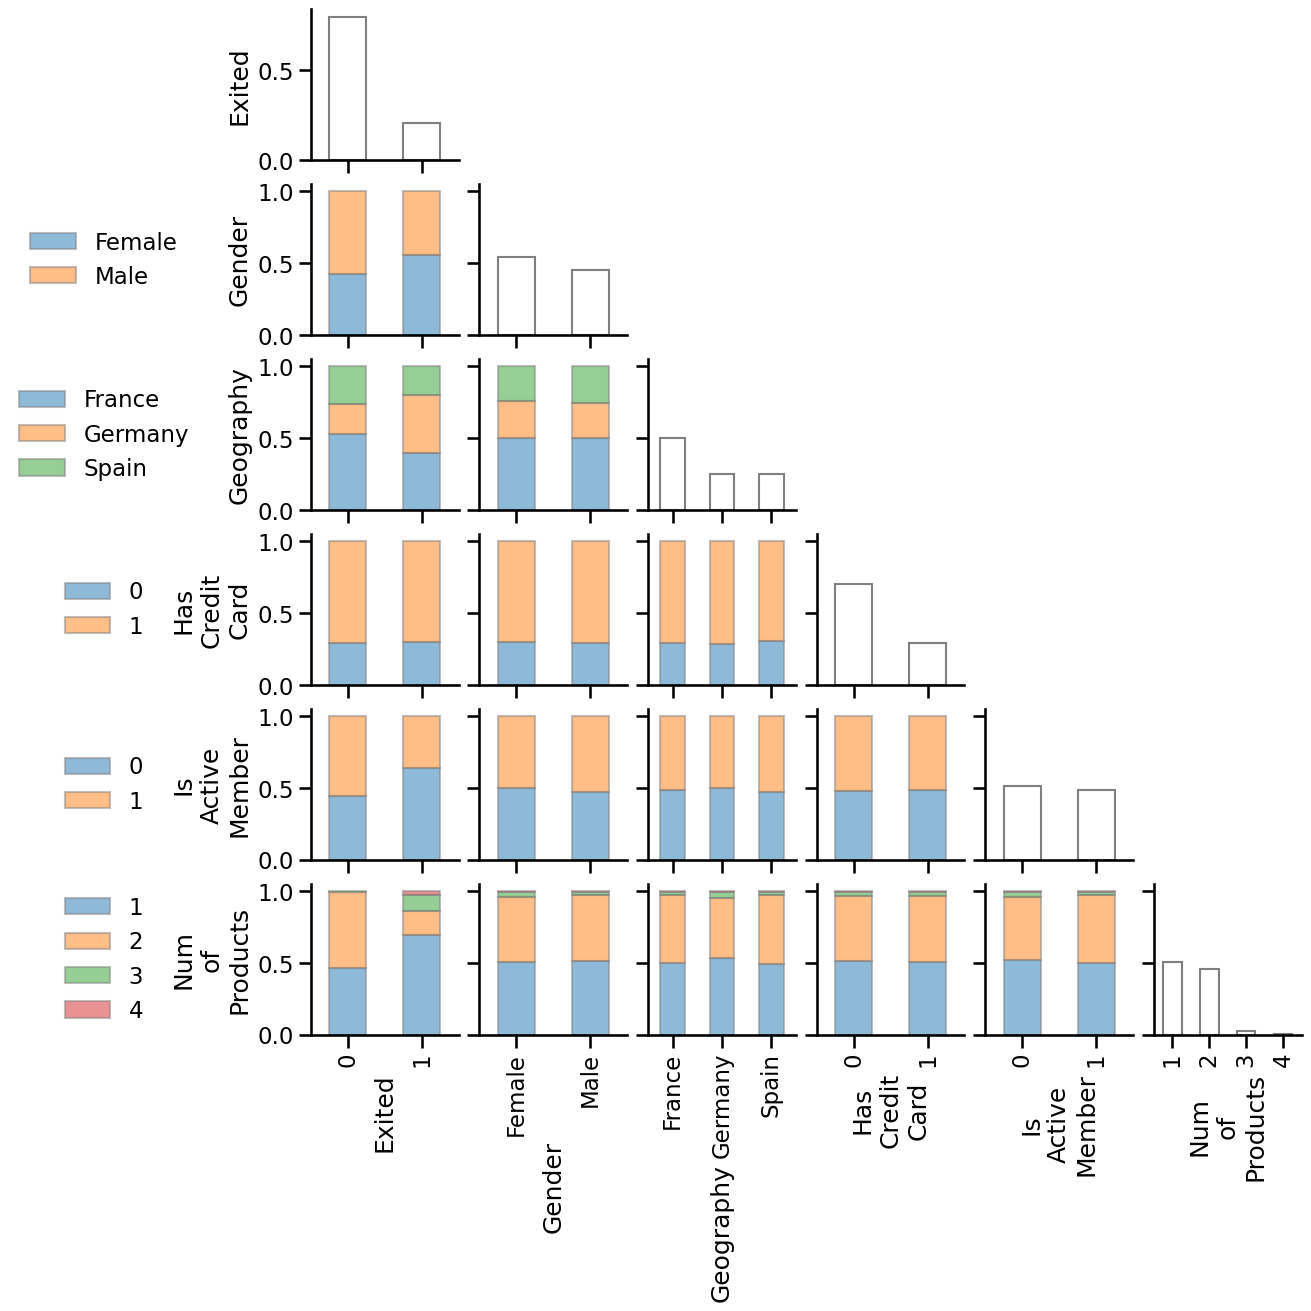

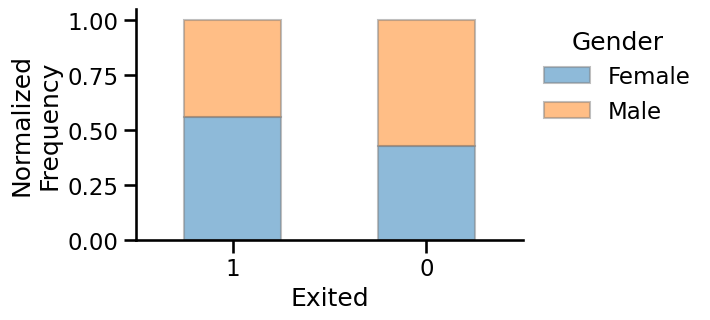

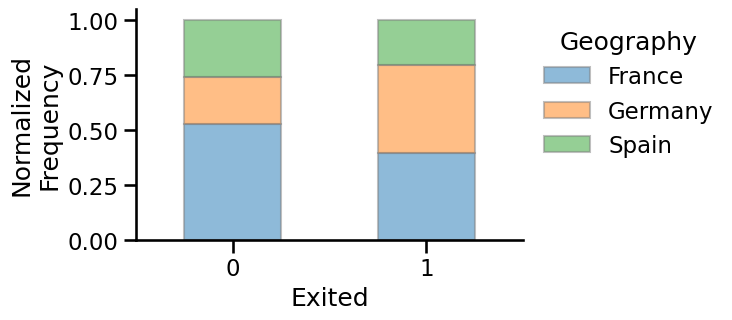

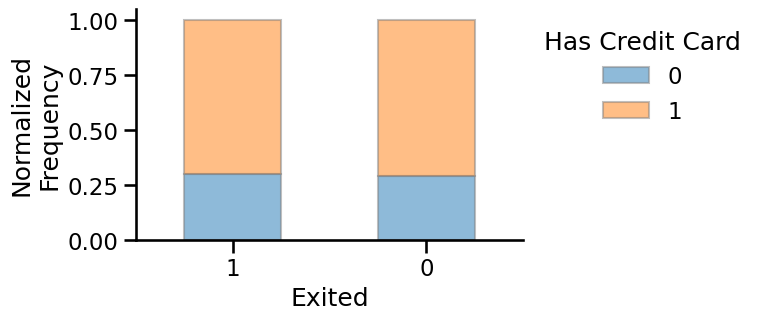

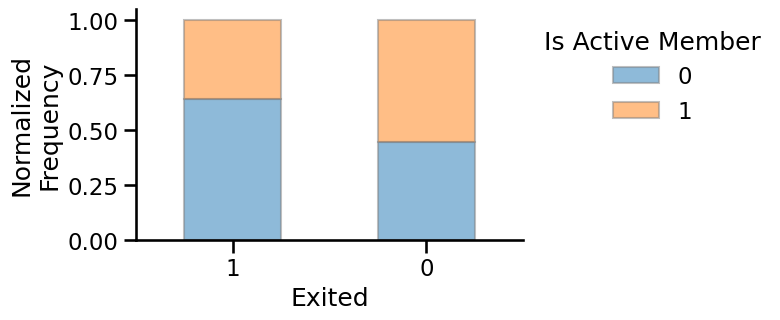

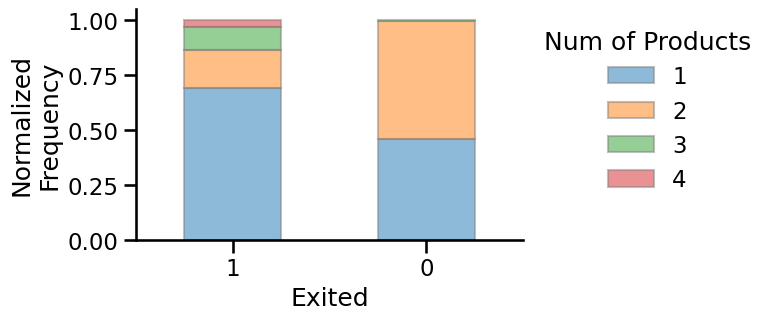

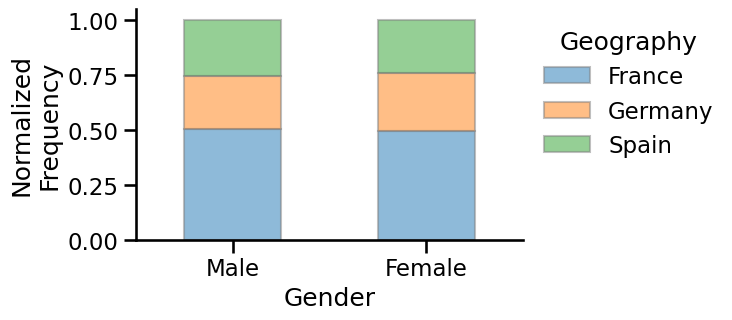

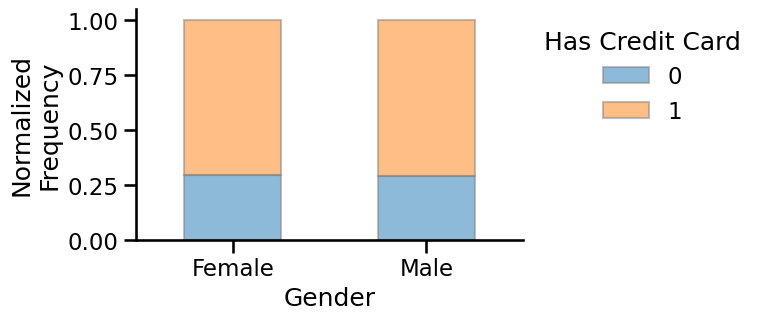

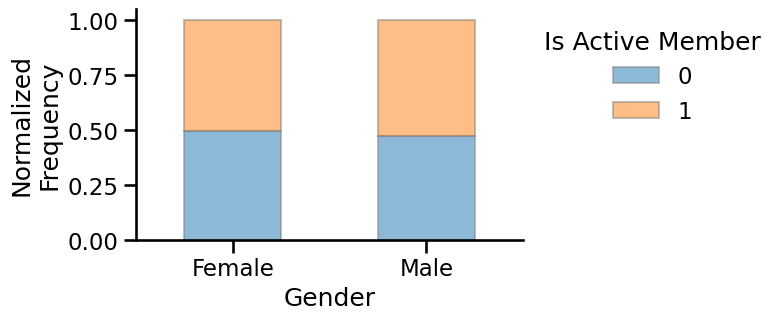

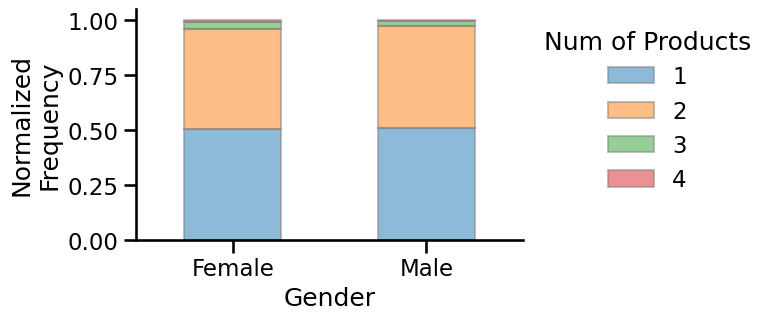

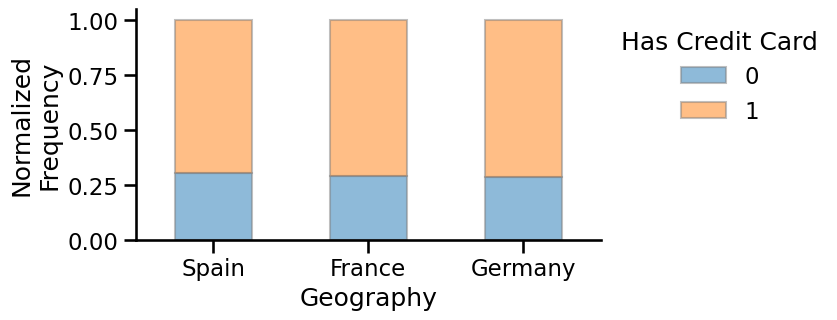

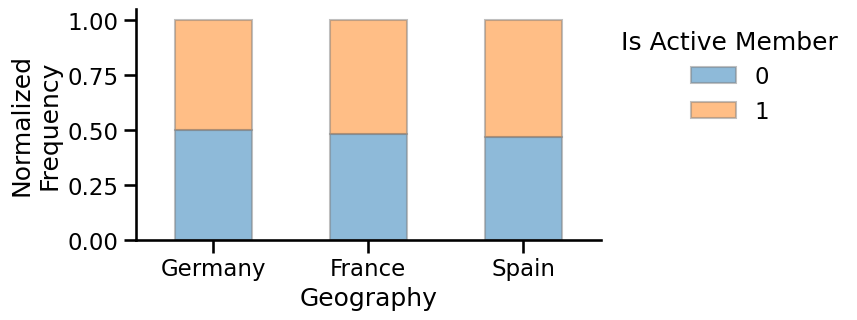

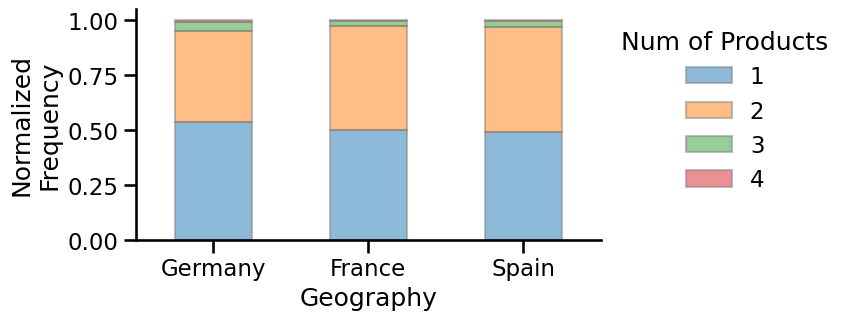

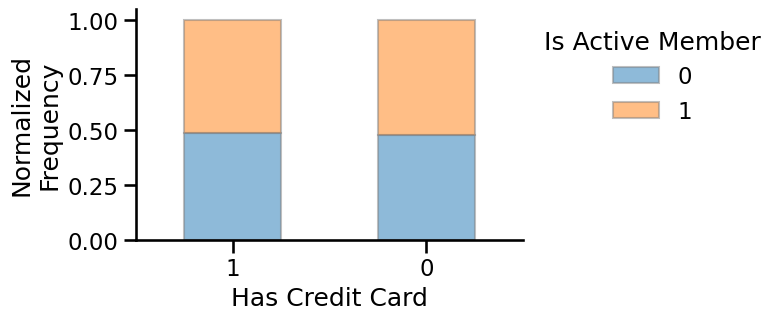

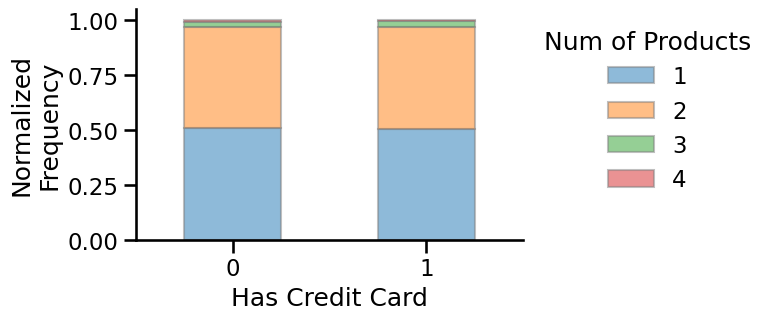

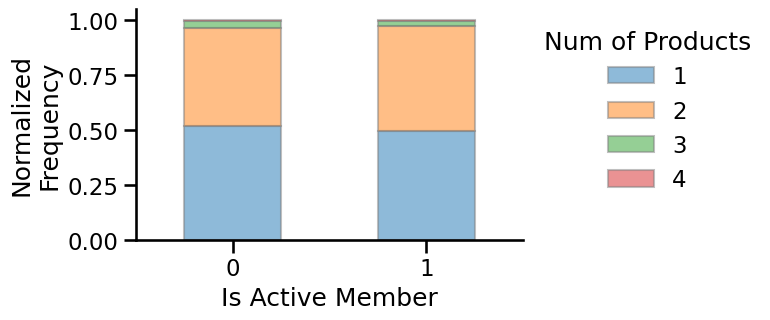

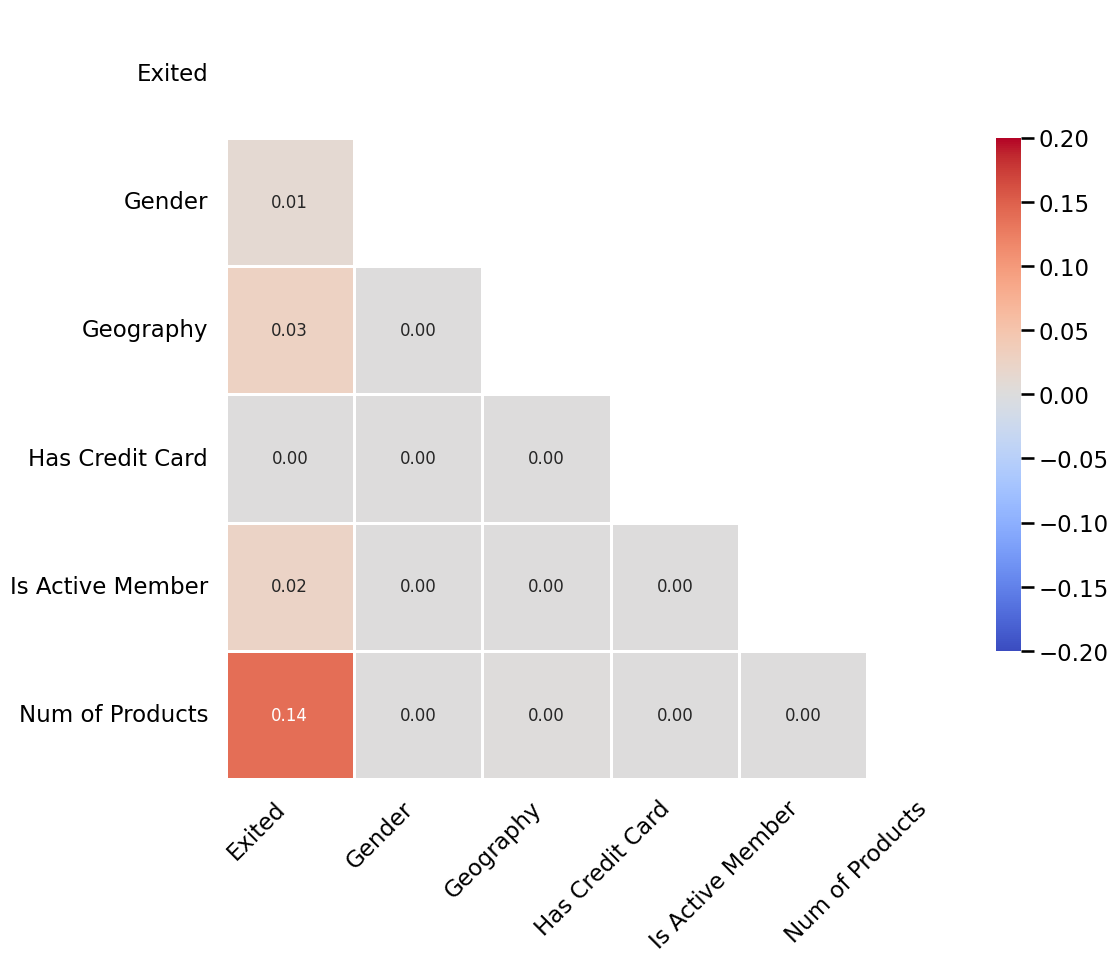

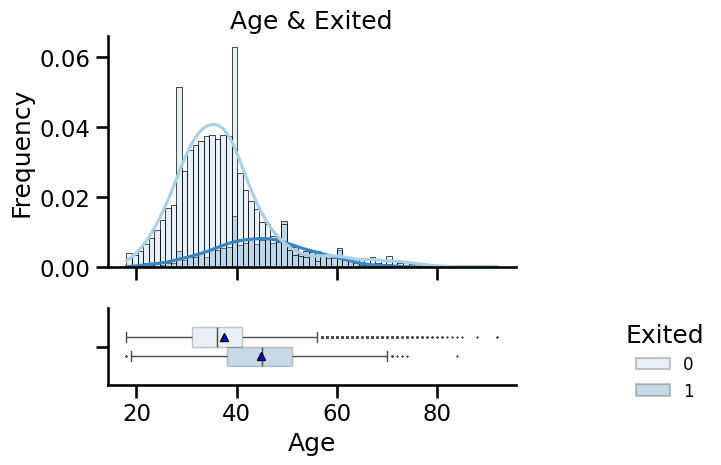

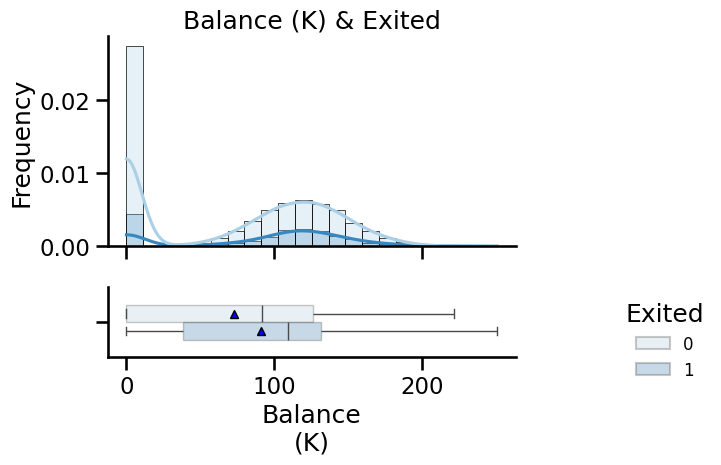

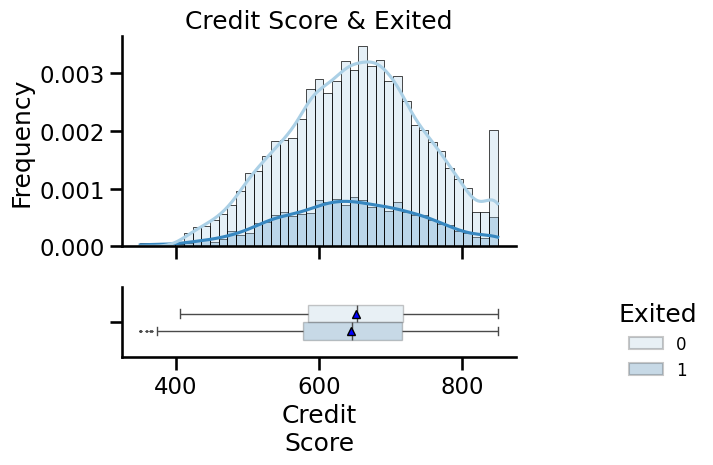

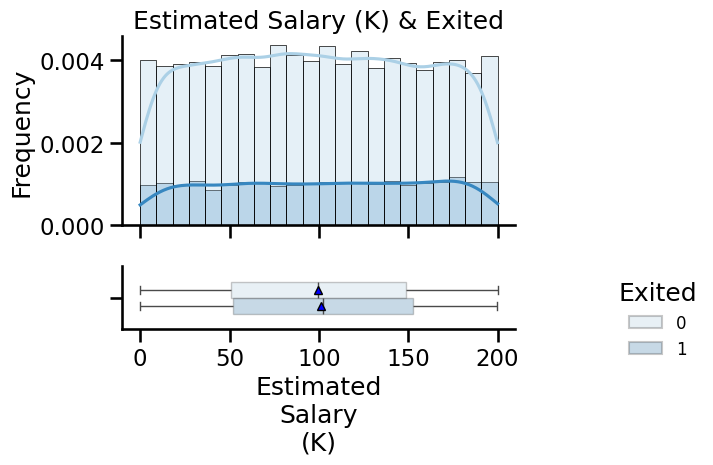

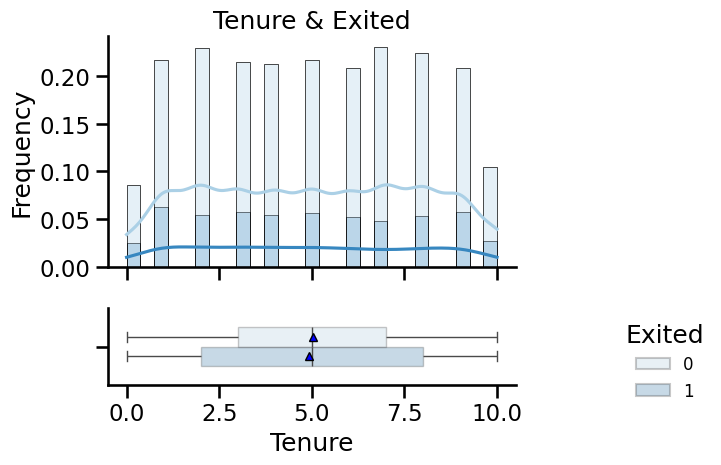

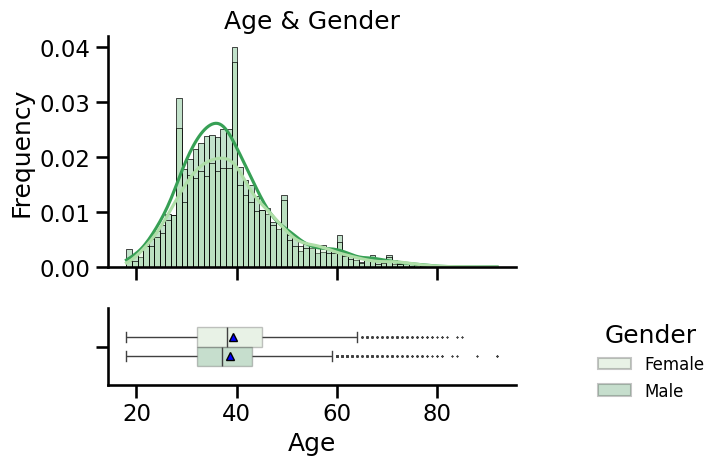

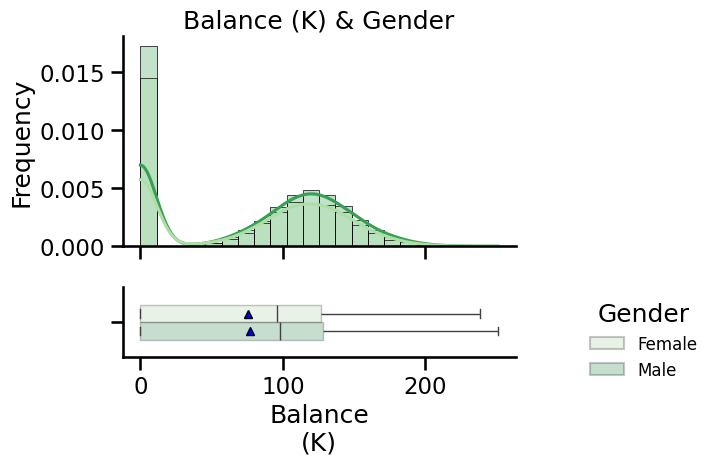

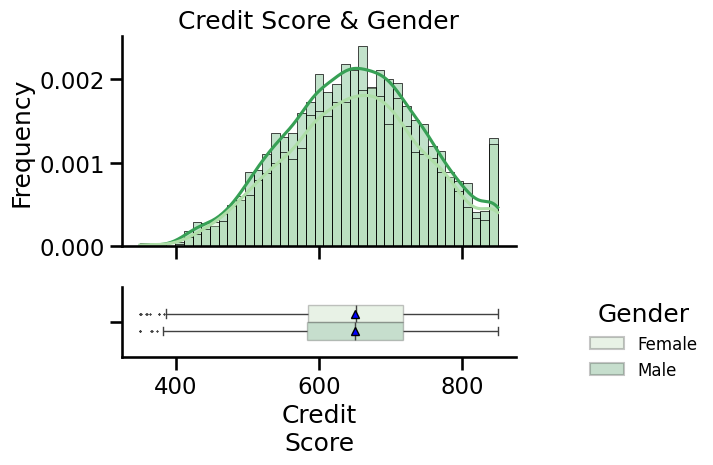

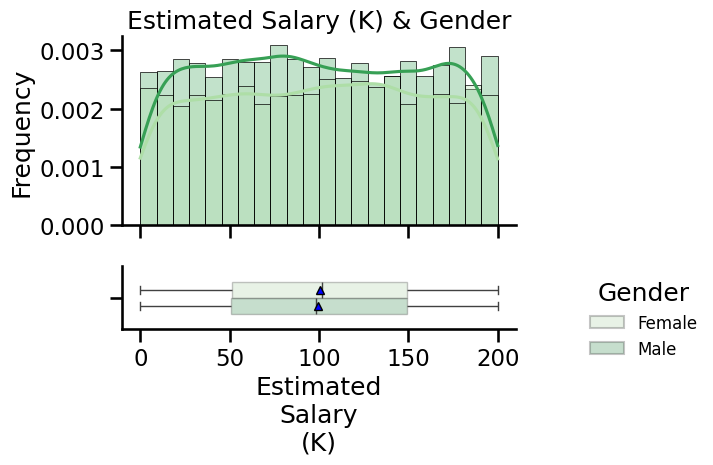

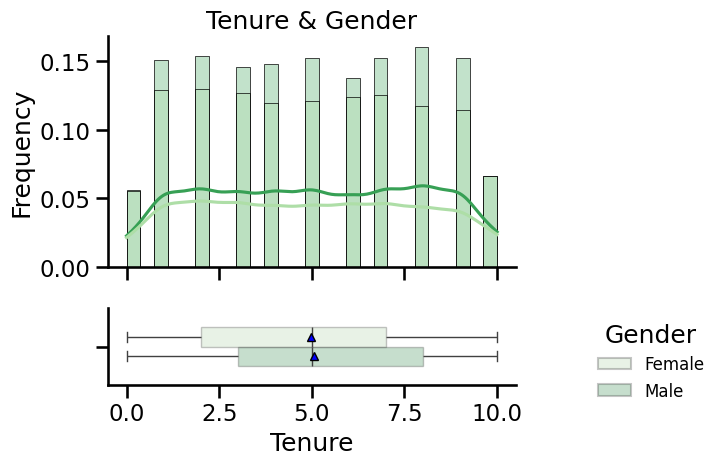

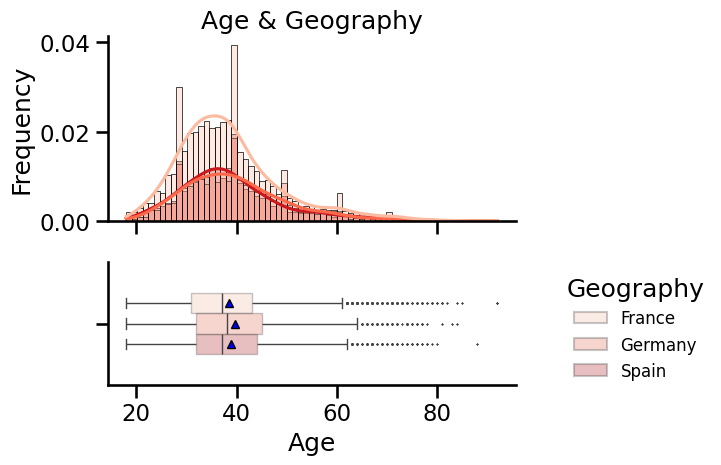

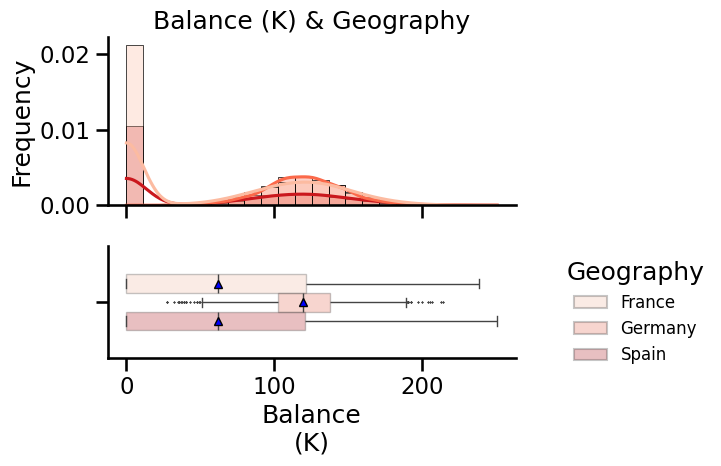

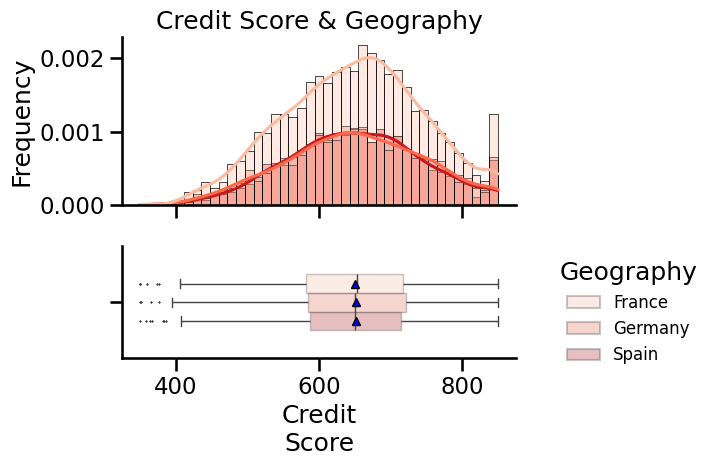

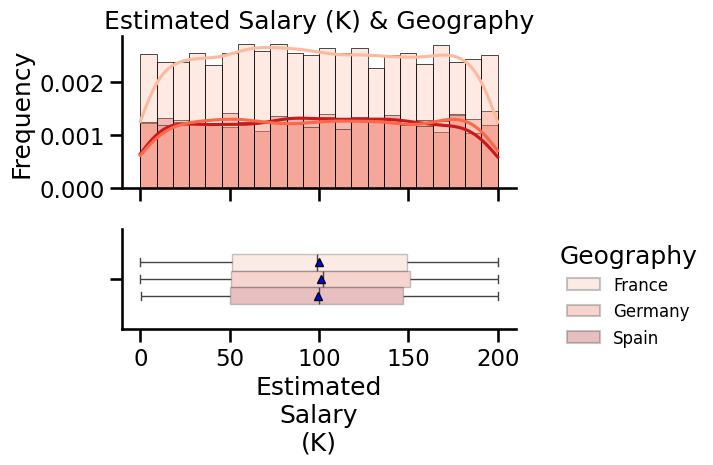

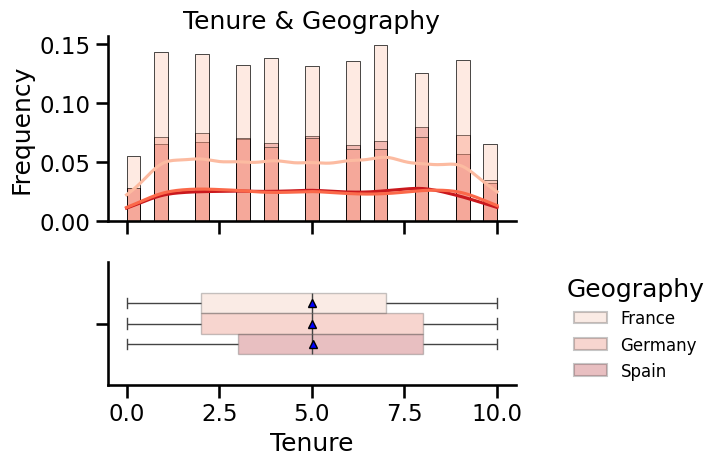

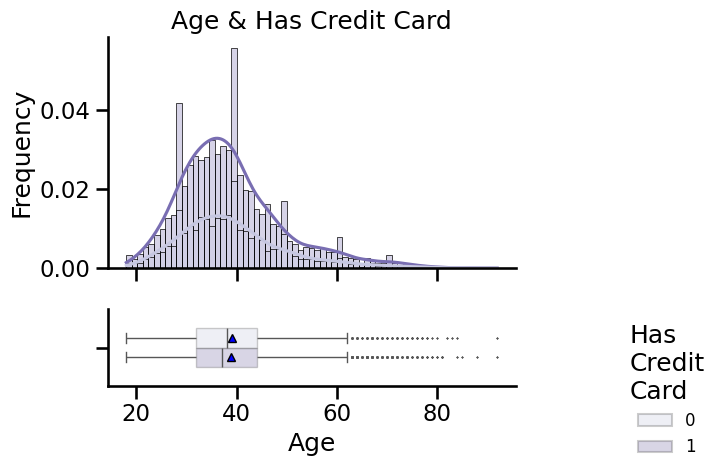

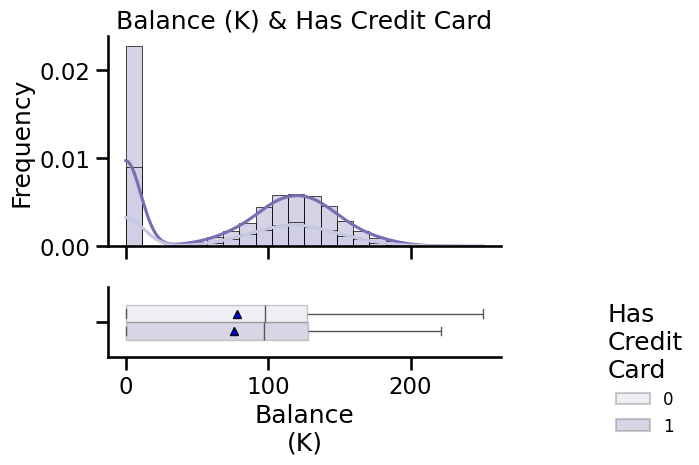

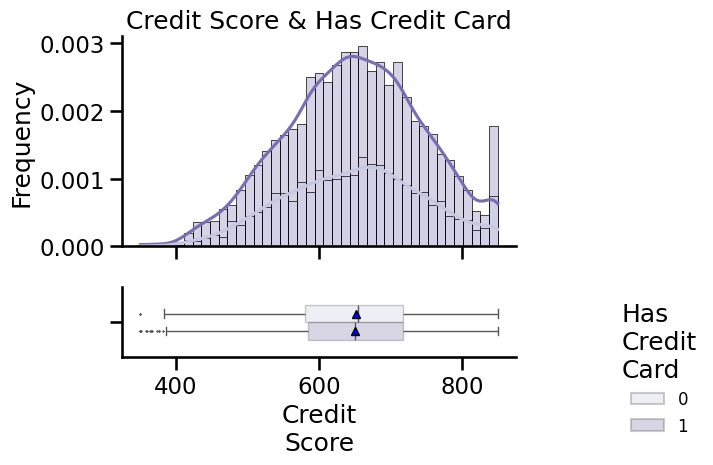

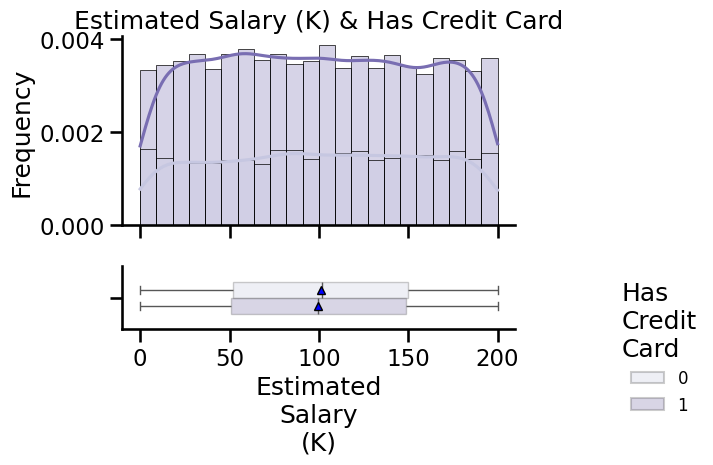

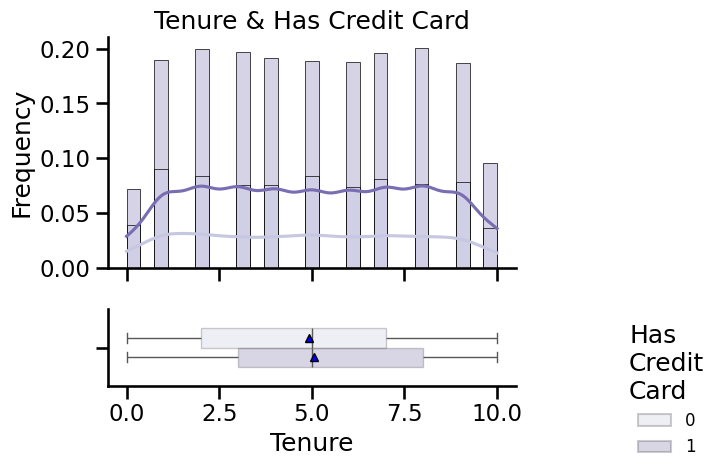

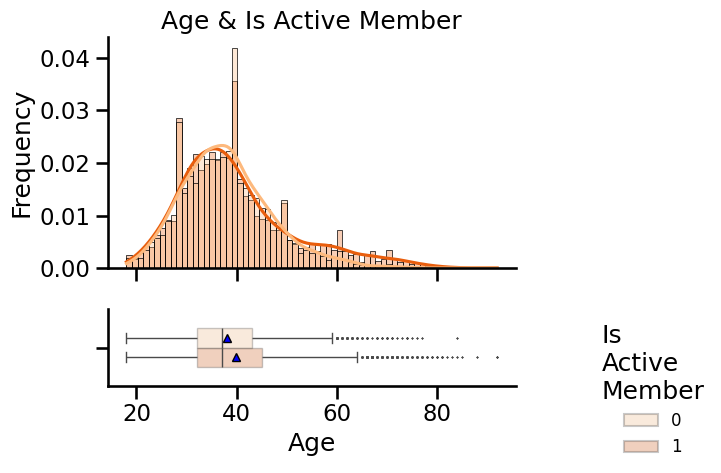

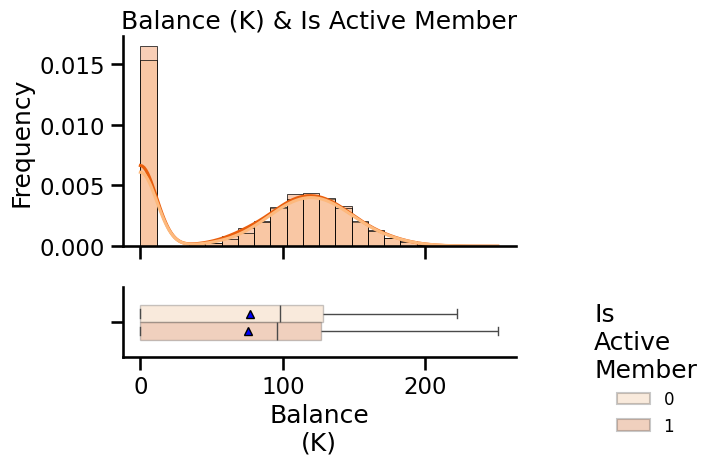

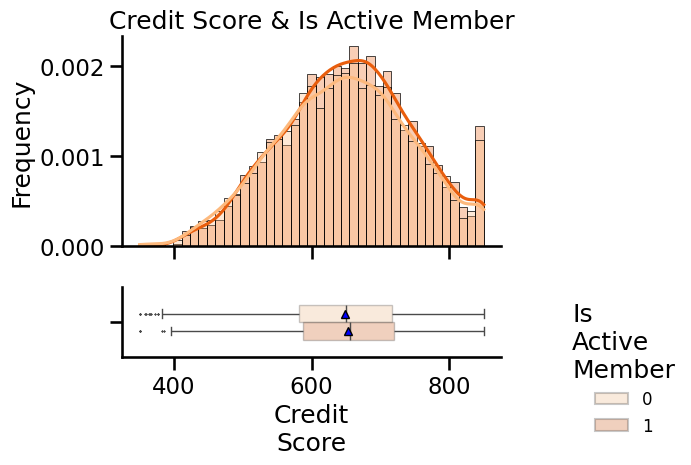

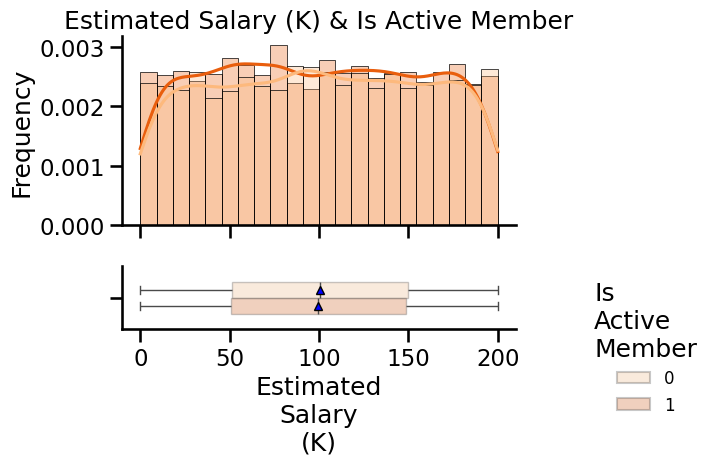

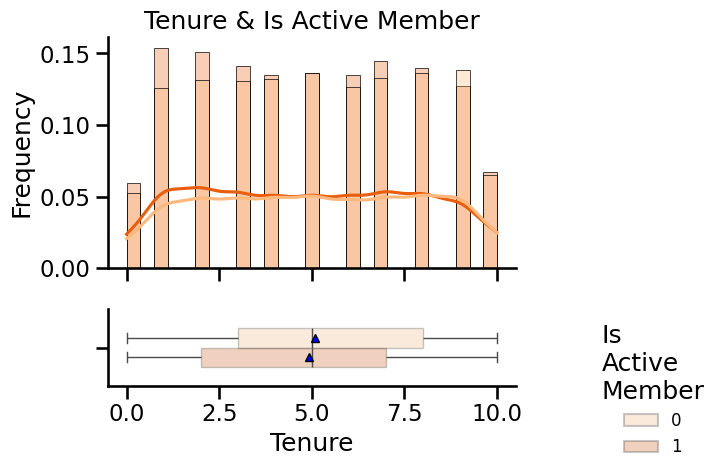

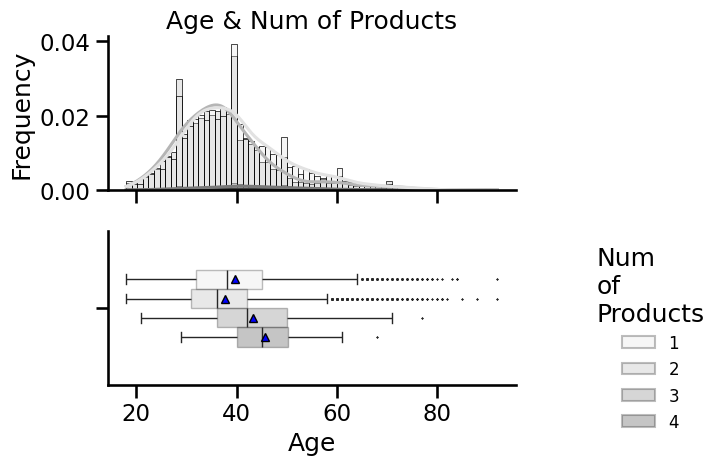

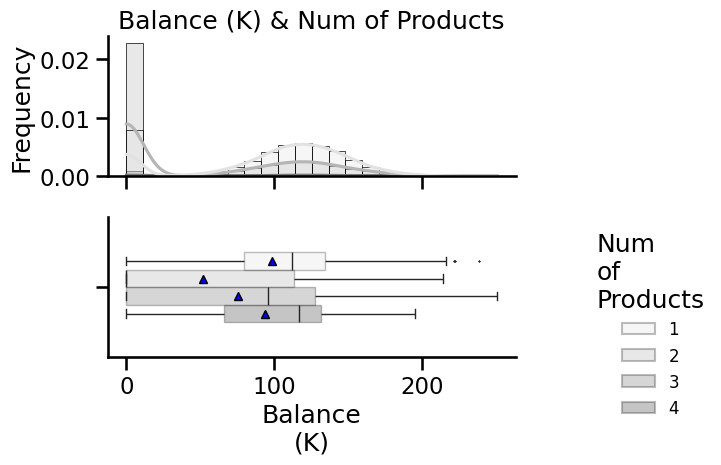

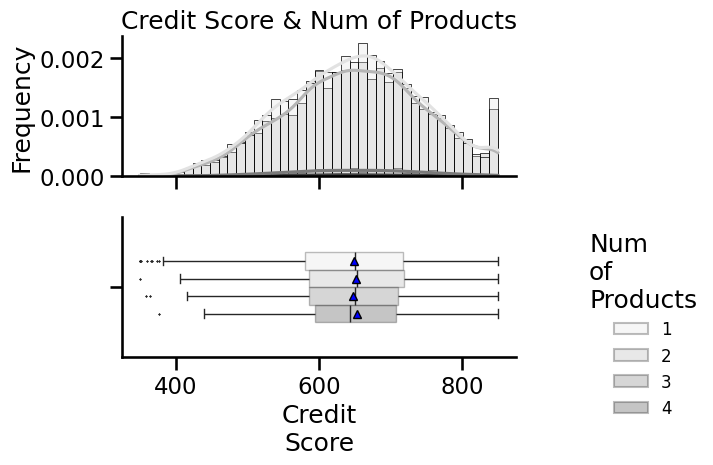

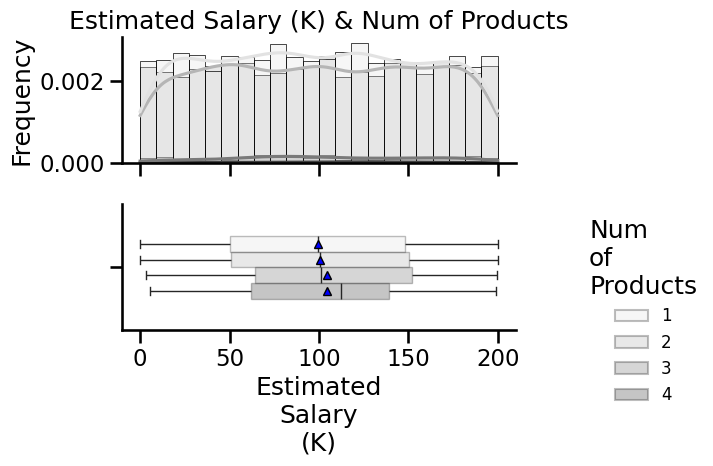

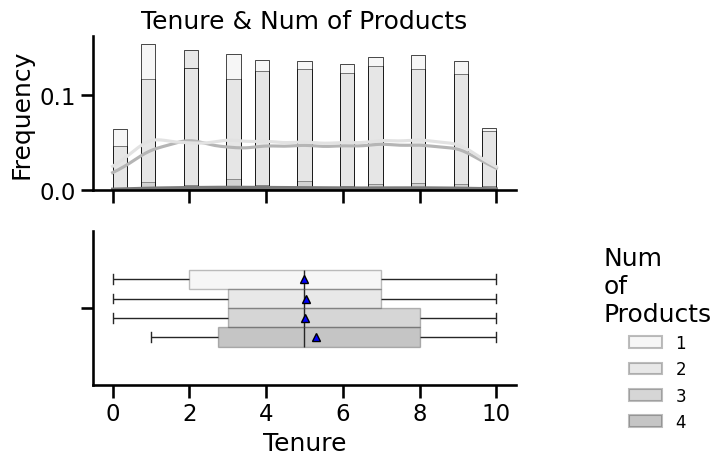

In [15]:
df = create_info_conduct_eda(df.copy(), positive_cols = positive_cols,
                        type_conv = type_conv,
                        feature_info = feature_info,
                  modify_dict = modify_dict,
                            drop_cols = drop_cols, ddict_str = ddict_str,
                             cat_orders=cat_orders, to_plot=True)